In [1]:
import aequitas

In [59]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [60]:
df = pd.read_csv("recid_aequitas.csv")

In [61]:
df.head()

,Unnamed: 0,race,gender,label_value,score
0,0,Other,Male,0,0
1,1,African-American,Male,1,0
2,2,African-American,Male,1,0
3,5,Other,Male,0,0
4,6,Caucasian,Male,1,1


The Aequitas tool always requires a ``score`` column and requires a binary ``label_value`` column for supervised metrics.

Note that while ``entity_id`` is not necessary for this example, Aequitas recognizes ``entity_id`` as a reserve column name and will not recognize it as an attribute column.

In [62]:
df = df.rename(columns={"Unnamed: 0": "entity_id"})

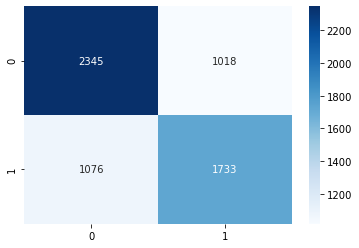

In [63]:
from sklearn.metrics import confusion_matrix

y_true = df.label_value
y_pred = df.score

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [64]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.6607258587167855

In [65]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.70      0.69      3363
           1       0.63      0.62      0.62      2809

    accuracy                           0.66      6172
   macro avg       0.66      0.66      0.66      6172
weighted avg       0.66      0.66      0.66      6172



# Group()

Aequitas’s ``Group()`` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population.

The ``get_crosstabs()`` method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

Note: The ``get_crosstabs()`` method expects a dataframe with predefined columns score, and label_value and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include race, sex and age_cat.

In [66]:
g = Group()
xtab, _ = g.get_crosstabs(df)

model_id, score_thresholds 0 {'rank_abs': [2751]}


In [67]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [68]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,2751,race,African-American,1829,1346,641,473,873,1188,1661,1514,3175,6172
1,0,binary 0/1,2751,race,Asian,7,24,2,3,21,5,8,23,31,6172
2,0,binary 0/1,2751,race,Caucasian,696,1407,282,408,999,414,822,1281,2103,6172
3,0,binary 0/1,2751,race,Hispanic,141,368,62,110,258,79,189,320,509,6172
4,0,binary 0/1,2751,race,Native American,8,3,3,0,3,5,5,6,11,6172
5,0,binary 0/1,2751,race,Other,70,273,28,82,191,42,124,219,343,6172
6,0,binary 0/1,2751,gender,Female,476,699,230,167,532,246,413,762,1175,6172
7,0,binary 0/1,2751,gender,Male,2275,2722,788,909,1813,1487,2396,2601,4997,6172


In [69]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.72,0.58,0.35,0.35,0.42,0.28,0.65,0.65,0.66,0.58,0.52
1,race,Asian,0.62,0.91,0.12,0.29,0.09,0.38,0.88,0.71,0.00,0.23,0.26
2,race,Caucasian,0.50,0.78,0.29,0.41,0.22,0.50,0.71,0.59,0.25,0.33,0.39
3,race,Hispanic,0.42,0.81,0.30,0.44,0.19,0.58,0.70,0.56,0.05,0.28,0.37
4,race,Native American,1.00,0.50,0.00,0.38,0.50,0.00,1.00,0.62,0.00,0.73,0.45
5,race,Other,0.34,0.87,0.30,0.40,0.13,0.66,0.70,0.60,0.03,0.20,0.36
6,gender,Female,0.60,0.70,0.24,0.48,0.30,0.40,0.76,0.52,0.17,0.41,0.35
7,gender,Male,0.62,0.70,0.33,0.35,0.30,0.38,0.67,0.65,0.83,0.46,0.48


In [70]:
aqp = Plot()

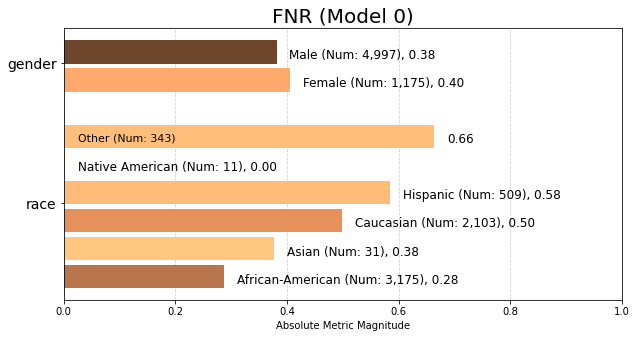

In [71]:
fnr = aqp.plot_group_metric(xtab, 'fnr')

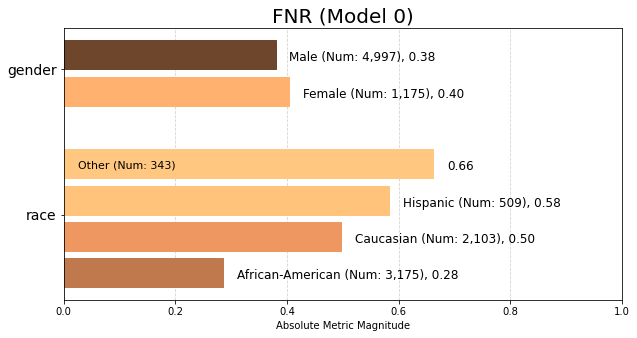

In [72]:
fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.01)

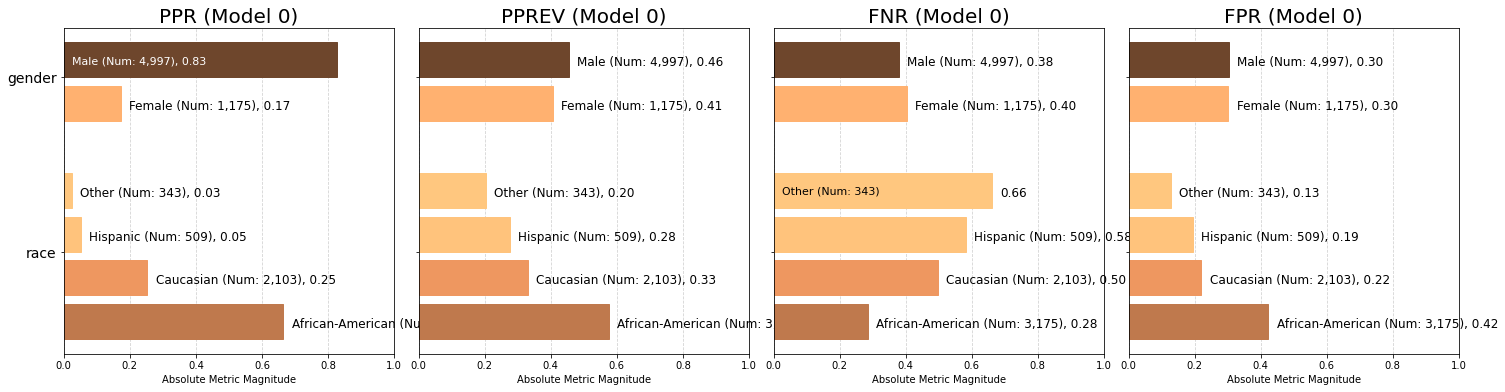

<Figure size 432x288 with 0 Axes>

In [73]:
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], min_group_size=0.01, ncols=4)

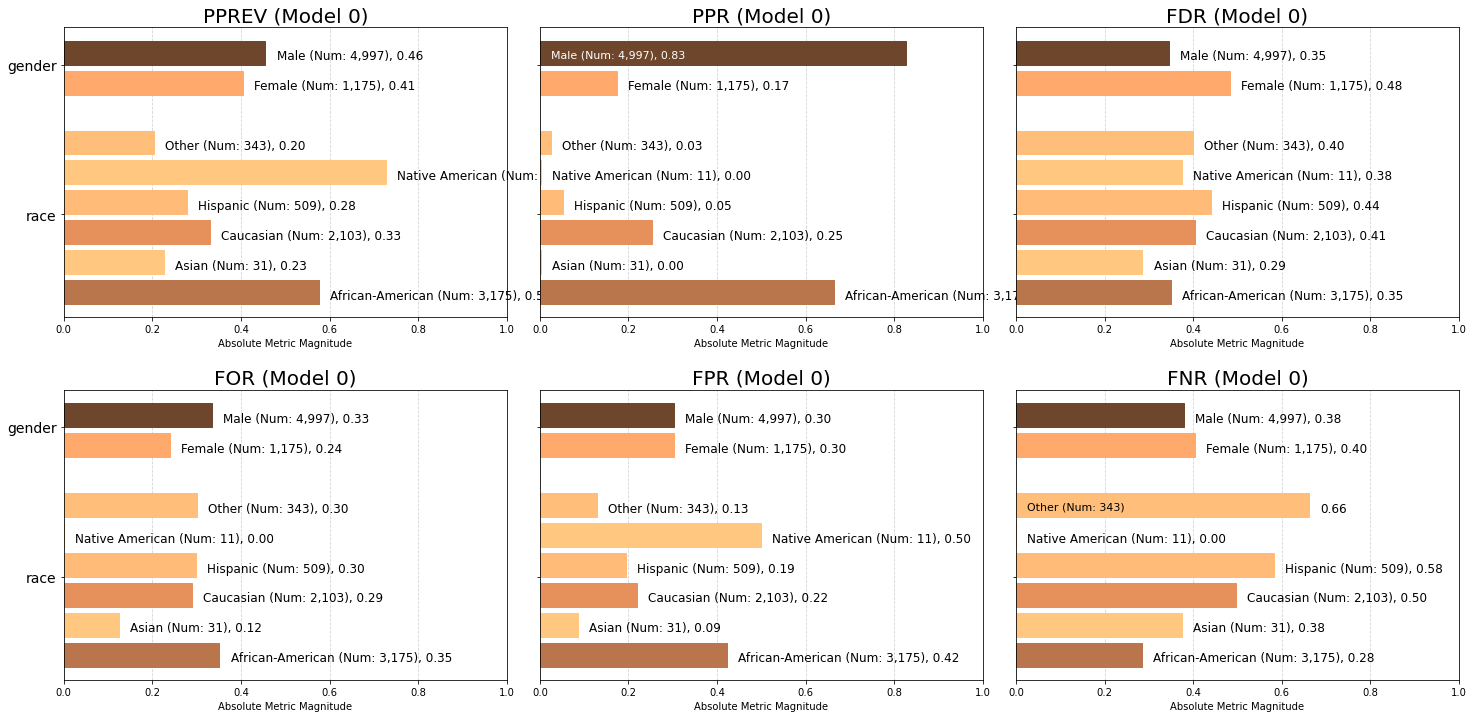

<Figure size 432x288 with 0 Axes>

In [74]:
a = aqp.plot_group_metric_all(xtab, ncols=3)

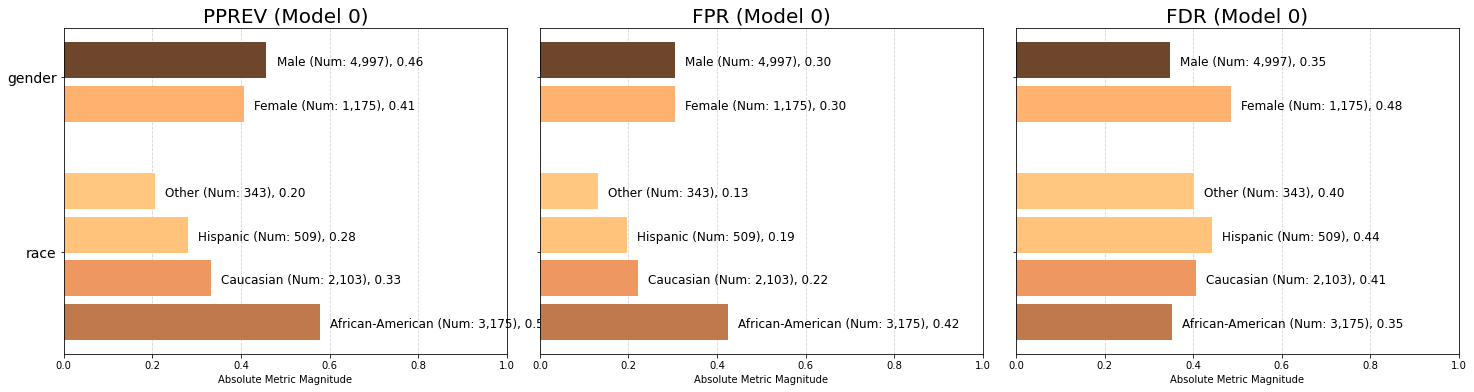

<Figure size 432x288 with 0 Axes>

In [75]:
my_plot = aqp.plot_group_metric_all(xtab, metrics=['pprev','fpr','fdr'], min_group_size=0.01, ncols=3)

# Bias()

In [76]:
b = Bias()

In [77]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict={'race':'Caucasian', 'gender':'Male'}, alpha=0.05, mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,2751,race,African-American,0.715232,0.576618,0.351412,0.350465,0.423382,0.284768,0.648588,0.649535,1829,1346,0.664849,0.576063,641,473,873,1188,1661,1514,3175,6172,0.523150,2.627874,1.740604,1.091972,0.864977,1.211853,1.923234,0.573724,1.420098,0.739387,0.913477,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
1,0,binary 0/1,2751,race,Asian,0.625000,0.913043,0.125000,0.285714,0.086957,0.375000,0.875000,0.714286,7,24,0.002545,0.225806,2,3,21,5,8,23,31,6172,0.258065,0.010057,0.682286,1.200828,0.705167,0.431066,0.395005,0.755515,1.240942,1.170779,1.232357,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
2,0,binary 0/1,2751,race,Caucasian,0.503650,0.779859,0.289979,0.405172,0.220141,0.496350,0.710021,0.594828,696,1407,0.252999,0.330956,282,408,999,414,822,1281,2103,6172,0.390870,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
3,0,binary 0/1,2751,race,Hispanic,0.417989,0.806250,0.298913,0.439716,0.193750,0.582011,0.701087,0.560284,141,368,0.051254,0.277014,62,110,258,79,189,320,509,6172,0.371316,0.202586,0.837011,0.941926,1.085257,1.030810,0.880120,1.172580,0.829921,1.033840,0.987417,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
4,0,binary 0/1,2751,race,Native American,1.000000,0.500000,0.000000,0.375000,0.500000,0.000000,1.000000,0.625000,8,3,0.002908,0.727273,3,0,3,5,5,6,11,6172,0.454545,0.011494,2.197492,1.050725,0.925532,0.000000,2.271277,0.000000,1.985507,0.641141,1.408408,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
5,0,binary 0/1,2751,race,Other,0.338710,0.872146,0.300366,0.400000,0.127854,0.661290,0.699634,0.600000,70,273,0.025445,0.204082,28,82,191,42,124,219,343,6172,0.361516,0.100575,0.616643,1.008696,0.987234,1.035822,0.580783,1.332306,0.672511,1.118338,0.985370,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
6,0,binary 0/1,2751,gender,Female,0.595642,0.698163,0.238913,0.483193,0.301837,0.404358,0.761087,0.516807,476,699,0.173028,0.405106,230,167,532,246,413,762,1175,6172,0.351489,0.209231,0.889809,0.790676,1.395006,0.715424,0.996293,1.065833,0.959756,1.001611,1.142680,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
7,0,binary 0/1,2751,gender,Male,0.620618,0.697040,0.333946,0.346374,0.302960,0.379382,0.666054,0.653626,2275,2722,0.826972,0.455273,788,909,1813,1487,2396,2601,4997,6172,0.479488,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male


In [78]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

calculated_disparities

['ppr_disparity',
 'pprev_disparity',
 'precision_disparity',
 'fdr_disparity',
 'for_disparity',
 'fpr_disparity',
 'fnr_disparity',
 'tpr_disparity',
 'tnr_disparity',
 'npv_disparity']

In [79]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,race,African-American,2.627874,1.740604,1.091972,0.864977,1.211853,1.923234,0.573724,1.420098,0.739387,0.913477
1,race,Asian,0.010057,0.682286,1.200828,0.705167,0.431066,0.395005,0.755515,1.240942,1.170779,1.232357
2,race,Caucasian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,race,Hispanic,0.202586,0.837011,0.941926,1.085257,1.030810,0.880120,1.172580,0.829921,1.033840,0.987417
4,race,Native American,0.011494,2.197492,1.050725,0.925532,0.000000,2.271277,0.000000,1.985507,0.641141,1.408408
5,race,Other,0.100575,0.616643,1.008696,0.987234,1.035822,0.580783,1.332306,0.672511,1.118338,0.985370
6,gender,Female,0.209231,0.889809,0.790676,1.395006,0.715424,0.996293,1.065833,0.959756,1.001611,1.142680
7,gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


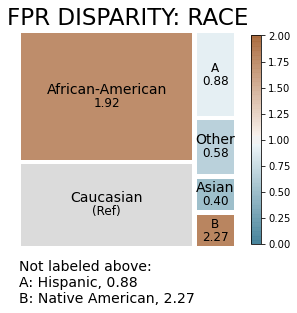

In [80]:
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race', significance_alpha=0.05)

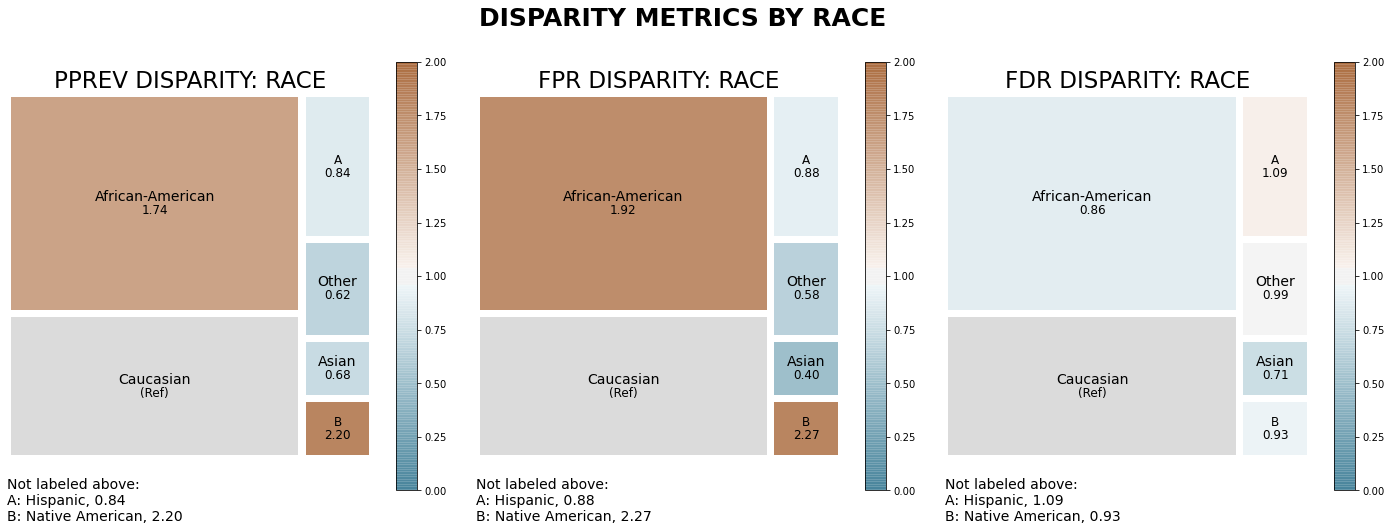

In [81]:
race = aqp.plot_disparity_all(bdf, attributes=['race'], metrics=['pprev','fpr','fdr'])

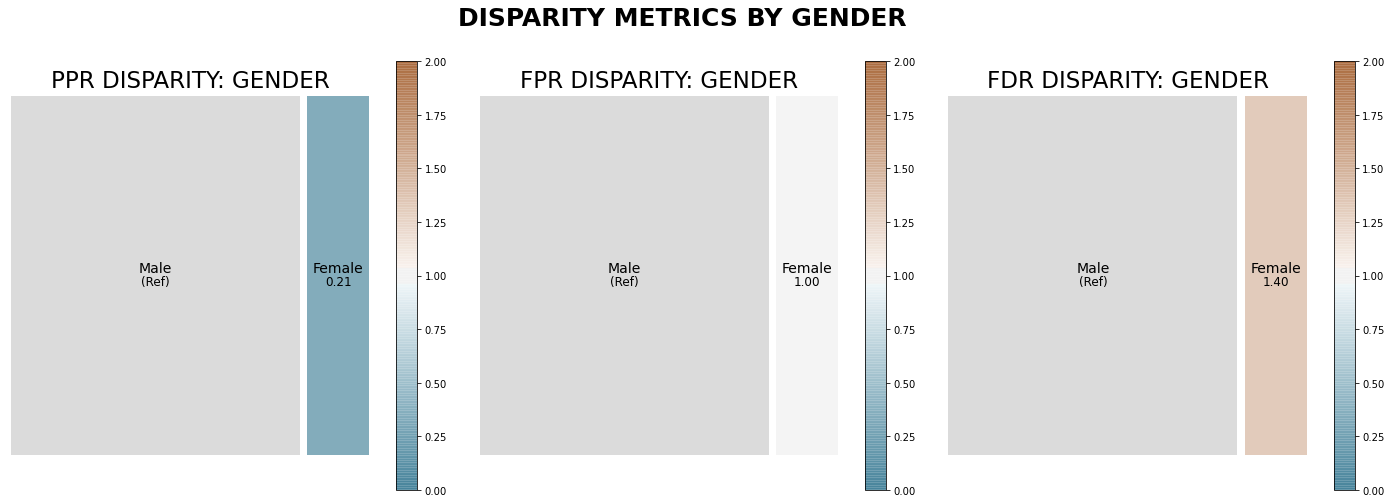

In [82]:
gender = aqp.plot_disparity_all(bdf, attributes=['gender'], metrics=['ppr','fpr','fdr'])

# Fairness()

In [83]:
f = Fairness()

In [84]:
fdf = f.get_group_value_fairness(bdf)

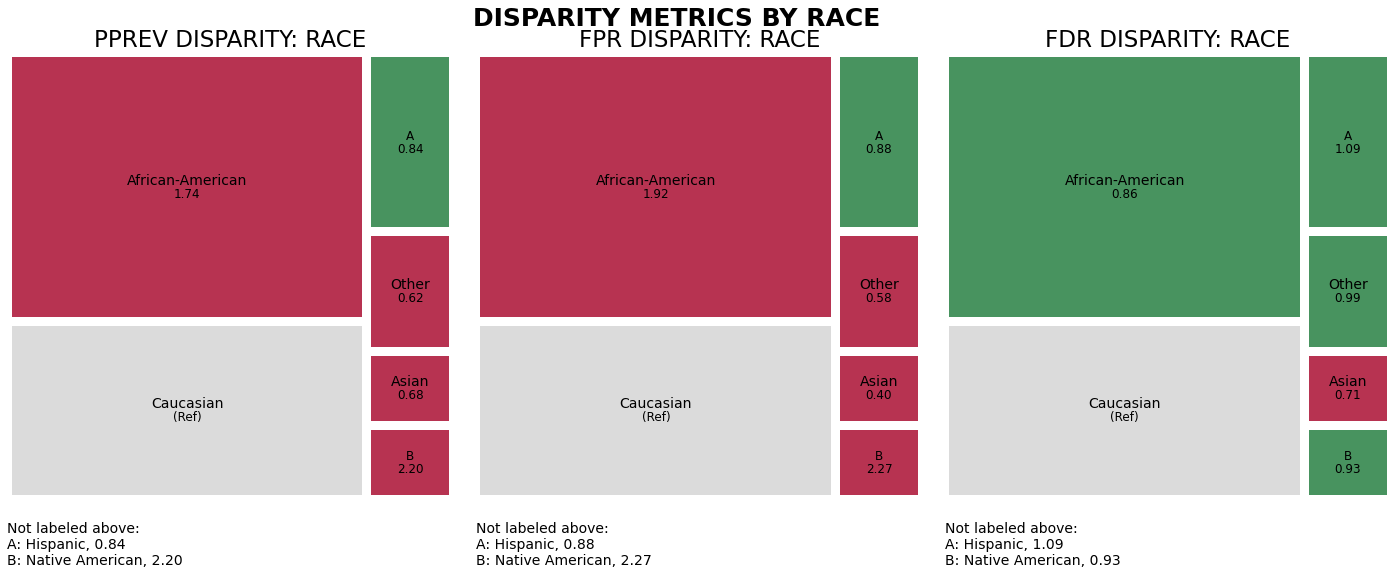

In [85]:
t = aqp.plot_fairness_disparity_all(fdf, attributes=['race'], metrics=['pprev','fpr','fdr'])

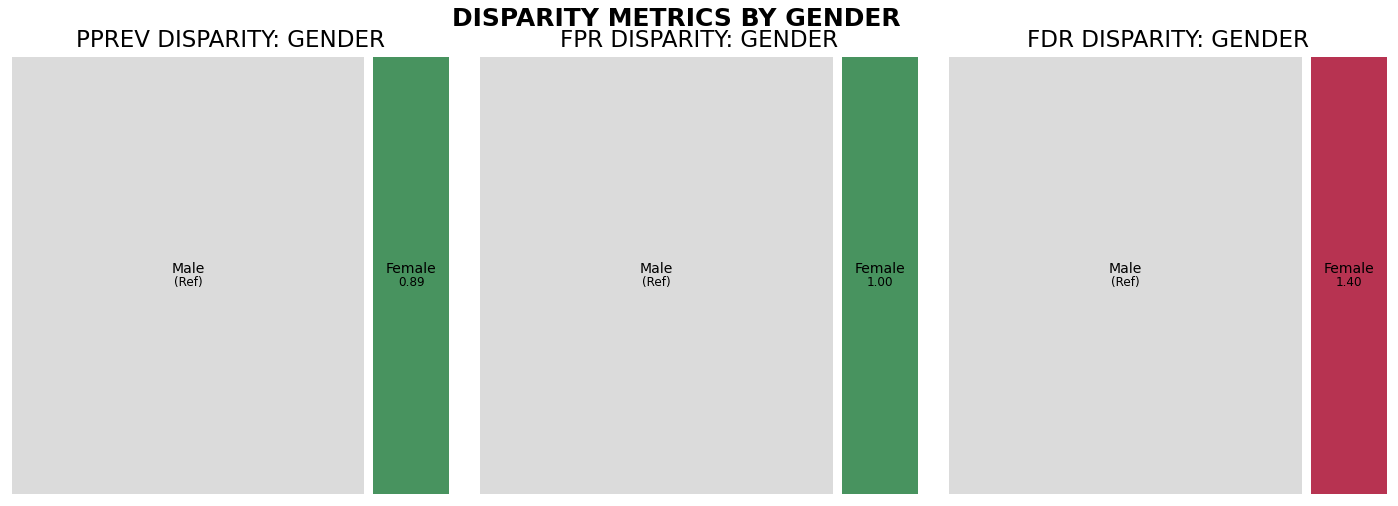

In [86]:
r = aqp.plot_fairness_disparity_all(fdf, attributes=['gender'], metrics=['pprev','fpr','fdr'])